In [1]:
# connect to GDrive for data
# folder: https://drive.google.com/drive/folders/1z9qUAX7fQfcAOX7FH-CerkKfMCj6OxWX
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bert-serving-client

In [2]:
import os

import math

import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split

import pickle

import tensorflow as tf

import matplotlib.pyplot as plt

# from transformers import BertTokenizer, TFBertModel

from tqdm.notebook import tqdm

In [ ]:
from bert_serving.client import BertClient

In [ ]:
bc = BertClient(ip='18.207.102.71')

In [ ]:
# Detect hardware
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)



Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
import subprocess as sp
import os

def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    print(memory_free_values)
    return memory_free_values

get_gpu_memory()

[15931]


[15931]

In [3]:
dir_prefix = "/content/drive/MyDrive/W266/data/Yelp"

In [4]:
max_sequence_length = 64
max_review_count = 50

In [5]:
# pool of all posssible review embeddings
bert_embeddings_raw_data = pd.read_pickle(os.path.join(dir_prefix,"yelp_train_val_dataset.pkl.gz")).drop_duplicates(subset=['asin','reviewerID'])
# the 'usable' rows which have >= 10 reviews per reviewerID and asin
bert_embeddings_usable = bert_embeddings_raw_data[(bert_embeddings_raw_data['userReviewsCount'] >=10) & 
                                                  (bert_embeddings_raw_data['itemReviewsCount'] >=10) &
                                                  (bert_embeddings_raw_data['userReviewsCount'] <= max_review_count) &
                                                   (bert_embeddings_raw_data['itemReviewsCount'] <= max_review_count)][['asin','reviewerID','overall']]
# sort the pool of possible review embeddings for quick retrieval
user_sorted_raw_data = bert_embeddings_raw_data.sort_values('reviewerID')
item_sorted_raw_data = bert_embeddings_raw_data.sort_values('asin')

In [ ]:
len(bert_embeddings_raw_data), len(bert_embeddings_usable)

(231413, 62934)

In [6]:
def fast_get_embeddings(sorted_user_data, sorted_item_data, user_item_row, embedding_column):
    # find the start and end indexes of the sorted user review data
    user_review_start_index = sorted_user_data['reviewerID'].searchsorted(user_item_row['reviewerID'],'left')
    user_review_end_index = sorted_user_data['reviewerID'].searchsorted(user_item_row['reviewerID'],'right')
    # we need at least 2 rows because the current combination is filtered out
    if user_review_end_index - user_review_start_index < 2:
        return None
    # use the index range to get the rows with tokenized reviews by this user
    user_reviews = sorted_user_data.iloc[user_review_start_index:user_review_end_index]
    # get all the user reviews except the one for the current item
    user_review_embedding_list = user_reviews[user_reviews['asin'] != user_item_row['asin']][['asin','reviewerID',embedding_column]]
    
    # find the start and end indexes of the sorted item review data
    item_review_start_index = sorted_item_data['asin'].searchsorted(user_item_row['asin'],'left')
    item_review_end_index = sorted_item_data['asin'].searchsorted(user_item_row['asin'],'right')
    # we need at least 2 rows because the current combination is filtered out
    if item_review_end_index - item_review_start_index < 2:
        return None
    # use the index range to get the rows with tokenized reviews for this item
    item_reviews = sorted_item_data.iloc[item_review_start_index:item_review_end_index]
    # get all the item reviews except the one for the current user
    item_review_embedding_list = item_reviews[item_reviews['reviewerID'] != user_item_row['reviewerID']][['asin','reviewerID',embedding_column]]
    
    return {'userReviews': user_review_embedding_list, 'itemReviews': item_review_embedding_list}

In [7]:
# Train/test split for our model is unique, we need to hold out a
# set of users and movies so that our network never learns those 
test_size = 0.05

# get test_size percentage of users
unique_users = bert_embeddings_usable.loc[:, "reviewerID"].unique()
users_size = len(unique_users)
test_idx = np.random.choice(users_size,
                              size=int(users_size * test_size),
                              replace=False)

# get test users
test_users = unique_users[test_idx]

# everyone else is a training user
train_users = np.delete(unique_users, test_idx)

test = bert_embeddings_usable[bert_embeddings_usable["reviewerID"].isin(test_users)]
train = bert_embeddings_usable[bert_embeddings_usable["reviewerID"].isin(train_users)]

unique_test_movies = test["asin"].unique()

# drop the movies that also appear in our test set. In order to be
# a true train/test split, we are forced to discard some data entirely
train = train.where(np.logical_not(train["asin"].isin(unique_test_movies))).dropna()

In [8]:
print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 34110
Test size: 3067


In [14]:
embedding_cache = {}

In [ ]:
len(embedding_cache)

0

In [ ]:
# Optional: Pre-load some cached embeddings
with open(os.path.join('/content/drive/MyDrive/W266/data/Yelp','yelp_held_out_test_mean_pool_embedding.pkl'), 'rb') as f:
    embedding_cache = pickle.load(f)

In [9]:
# the training set generator groups together the reviews from the 
# review pool when each row is fed into the model.  The grouped review embeddings
# are avearged together resulting in 1x768 vector
generator_batch_size=50
embedding_size = 768
def dataset_generator(row, user_sorted_data, item_sorted_data):
    # get the grouped list of embedding vectors for userReviews and itemReviews
    review_lists = fast_get_embeddings(user_sorted_data, item_sorted_data, row, 'reviewText')
    
#     user_embedding = tf.reduce_mean(bc.encode(review_lists['userReviews']['reviewText'].tolist()),axis=0)
#     item_embedding = tf.reduce_mean(bc.encode(review_lists['itemReviews']['reviewText'].tolist()),axis=0)

    embedding_lists = {}
    for reviewType in ['userReviews','itemReviews']:
        embedding_lists[reviewType] = []
        review_lists[reviewType]['embedding'] = review_lists[reviewType].apply(lambda x: embedding_cache.get(f"{x['reviewerID']}-{x['asin']}",None), axis=1)

        empty_embeddings_mask = review_lists[reviewType]['embedding'].isnull()

        if len(review_lists[reviewType][empty_embeddings_mask]) > 0:
            for i in range(0, math.ceil(len(empty_embeddings_mask) / generator_batch_size)):
                reviewTexts = review_lists[reviewType][empty_embeddings_mask].iloc[i*generator_batch_size:(i+1)*generator_batch_size]['reviewText'].tolist()
                if len(reviewTexts) > 0:
                    #embedding_lists[reviewType] += tf.unstack(bert_model(bert_tokenizer(reviewTexts, padding='max_length', truncation=True, return_tensors="tf", max_length=max_sequence_length)).last_hidden_state,axis=0)
                    embedding_lists[reviewType] += tf.unstack(bc.encode(reviewTexts),axis=0)
            review_lists[reviewType].loc[empty_embeddings_mask,'embedding'] = embedding_lists[reviewType]
            for embedding_pair in list(zip(review_lists[reviewType][empty_embeddings_mask][['asin','reviewerID']].apply(lambda x: f"{x['reviewerID']}-{x['asin']}",axis=1), embedding_lists[reviewType])):
                embedding_cache[embedding_pair[0]] = embedding_pair[1]

    user_embedding = tf.stack(review_lists['userReviews']['embedding'].tolist() + embedding_lists['userReviews'])
    item_embedding = tf.stack(review_lists['itemReviews']['embedding'].tolist() + embedding_lists['itemReviews'])
    #user_embedding = tf.reduce_mean(tf.reduce_mean(tf.stack(review_lists['userReviews']['embedding'].tolist() + embedding_lists['userReviews'], axis=0)[:,1:-1,:],axis=1),axis=0)
    #item_embedding = tf.reduce_mean(tf.reduce_mean(tf.stack(review_lists['itemReviews']['embedding'].tolist() + embedding_lists['itemReviews'], axis=0)[:,1:-1,:],axis=1),axis=0)
    #user_embedding = tf.pad(user_embedding, tf.constant([[0,max_review_count-user_embedding.shape[0]],[0,0]]))
    # user_embedding_mask = tf.constant([True for i in range(user_embedding.shape[0])] + [False for i in range(max_review_count-user_embedding.shape[0])])
    #item_embedding = tf.pad(item_embedding, tf.constant([[0,max_review_count-item_embedding.shape[0]],[0,0]]))
    # item_embedding_mask = tf.constant([True for i in range(item_embedding.shape[0])] + [False for i in range(max_review_count-item_embedding.shape[0])])
    # return the userReviews, itemReviews and rating in a dict
    return ({'user_embedding': tf.expand_dims(tf.reduce_mean(user_embedding,axis=0), axis=0),
            #  'user_embedding_mask': tf.expand_dims(user_embedding_mask, axis=0),
             'item_embedding': tf.expand_dims(tf.reduce_mean(item_embedding,axis=0), axis=0),
            #  'item_embedding_mask': tf.expand_dims(item_embedding_mask, axis=0),
          #'user_token_type_ids': [user_sentences_batch.data['token_type_ids']], 
          # 'user_attention_masks': [user_sentences_batch.data['attention_mask']],
          # 'item_input_ids': [item_sentences_batch.data['input_ids']],
          #'item_token_type_ids': [item_sentences_batch.data['token_type_ids']],
          # 'item_attention_masks': [item_sentences_batch.data['attention_mask']]
          },
                  {'rating': tf.expand_dims(row['overall'],axis=0)})

def train_dataset_generator():
    # iterate through each training row
    # limit to 1000 rows
    for _, row in train.iterrows():
        yield dataset_generator(row, user_sorted_raw_data, item_sorted_raw_data)

# create tf.dataset object from generator w/ signature
train_dataset = tf.data.Dataset.from_generator(train_dataset_generator,
                   output_signature=({'user_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32),
                                      # 'user_embedding_mask': tf.TensorSpec(shape=(None, max_review_count), dtype=tf.bool),
                                      'item_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32),
                                      # 'item_embedding_mask': tf.TensorSpec(shape=(None, max_review_count), dtype=tf.bool)
                                      },
                           {'rating':tf.TensorSpec(shape=(None), dtype=tf.float32)}))


In [ ]:
list(train_dataset.take(1))

[({'item_embedding': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
   array([[ 3.07400133e-02, -1.55524880e-01,  2.68929690e-01,
            2.54274663e-02,  2.70467371e-01, -1.06452323e-01,
           -4.45499644e-02,  1.00380158e+00, -9.92540568e-02,
           -2.17992336e-01,  1.21525727e-01, -2.97500432e-01,
            7.94870928e-02,  2.21388295e-01, -2.78488487e-01,
            4.67562884e-01,  2.67627358e-01,  2.49821141e-01,
           -2.88701743e-01,  2.59378940e-01,  3.63985956e-01,
           -3.01555425e-01, -2.59863943e-01,  4.46624845e-01,
            2.22635850e-01,  2.33066365e-01, -8.60547051e-02,
           -5.30202650e-02, -2.00634181e-01, -9.94000956e-02,
            5.69753587e-01,  1.59049079e-01,  2.32814461e-01,
           -1.34376660e-01,  1.87054500e-01, -3.63897026e-01,
            5.09393960e-02,  1.58694431e-01, -1.32602021e-01,
            3.95468101e-02, -3.23356032e-01, -2.90518880e-01,
            6.43984139e-01, -1.35423899e-01, -5.85148707e-02,

In [ ]:
for _ in tqdm(train_dataset, total=len(train)):
  pass
len(embedding_cache)

175930

In [ ]:
# same thing as training_dataset_generator but loops over test data
def test_dataset_generator():
    # iterate through each testing row
    for _, row in test.iterrows():
        # get the grouped list of embedding vectors for userReviews and itemReviews
        yield dataset_generator(row, user_sorted_raw_data, item_sorted_raw_data)

# create tf.dataset object from generator w/ signature
test_dataset = tf.data.Dataset.from_generator(test_dataset_generator, 
                    output_signature=({'user_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32),
                                      'item_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32)
                                      #'user_token_type_ids': tf.TensorSpec(shape=(None, None, max_sentence_length), dtype=tf.int32),
                                      #'user_attention_masks': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32),
                                      #'item_input_ids': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32),
                                      #'item_token_type_ids': tf.TensorSpec(shape=(None, None, max_sentence_length), dtype=tf.int32),
                                      #'item_attention_masks': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32)
                    },
                           {'rating':tf.TensorSpec(shape=(None), dtype=tf.float32)}))


In [ ]:
for _ in tqdm(test_dataset, total=len(test)):
  pass
len(embedding_cache)

176017

In [ ]:
# modeling imports

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Input, Dense, LSTM, Masking
from tensorflow.keras.layers import Add, Dot, Concatenate, Layer, Dropout, MultiHeadAttention, LayerNormalization

In [ ]:
class RecommenderConfig():

      def __init__(self, max_len=64, hidden_dim=32, embedding_dim = 768*4, 
               num_heads=2, feedforward_dim=32, rate=0.1):
    
        self.max_len = max_len
        self.hidden_dim = hidden_dim
        self.rate = rate

        # this configuration is for transformer layer
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim
    
class EncoderLayer(Layer):

    def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

        super().__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.feedforward = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        feedforward_output = self.feedforward(out1)
        feedforward_output = self.dropout2(feedforward_output, training=training)
        return self.layernorm2(out1 + feedforward_output)


class DecoderLayer(Layer):

    def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

        super().__init__()

        self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        self.feedforward = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

  
    def call(self, inputs, enc_output, training):
    
        attn_output1 = self.attn1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs + attn_output1)

        attn_output2 = self.attn2(enc_output, enc_output) #, out1
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm2(out1 + attn_output2)

        feedforward_output = self.feedforward(out2)
        feedforward_output = self.dropout3(feedforward_output, training=training)

        return self.layernorm3(out2 + feedforward_output)


class TransformerLayer(Layer):

    def __init__(self, recommender_config):
        super().__init__()

        embedding_dim = recommender_config.embedding_dim
        num_heads = recommender_config.num_heads
        feedforward_dim = recommender_config.feedforward_dim
        rate = recommender_config.rate

        self.encoder = EncoderLayer(embedding_dim, num_heads, feedforward_dim, rate)
        self.decoder = DecoderLayer(embedding_dim, num_heads, feedforward_dim, rate)

    def call(self, inputs, training):

        out = self.encoder(inputs, training)
        out = self.decoder(inputs, out, training)

        return out

In [ ]:
class EncoderLayerModified(Layer):

    def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

        super().__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.feedforward1 = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.feedforward2 = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)


    def call(self, inputs, training):
    
        feedforward_output1 = self.feedforward1(inputs)
        feedforward_output1 = self.dropout1(feedforward_output1, training=training)
        feedforward_output1 = self.layernorm1(inputs + feedforward_output1)

        attn_output = self.attn(feedforward_output1, feedforward_output1)
        attn_output = self.dropout2(attn_output, training=training)
        attn_output = self.layernorm2(feedforward_output1 + attn_output)

        feedforward_output2 = self.feedforward2(attn_output)
        feedforward_output2 = self.dropout3(feedforward_output2, training=training)
        return self.layernorm3(attn_output + feedforward_output2)


class DecoderLayerModified(Layer):

    def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

        super().__init__()

        self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        self.feedforward1 = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.feedforward2 = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.feedforward3 = Sequential(
            [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.layernorm4 = LayerNormalization(epsilon=1e-6)
        self.layernorm5 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)
        self.dropout4 = Dropout(rate)
        self.dropout5 = Dropout(rate)

  
    def call(self, inputs, enc_output, training):
    
        feedforward_output1 = self.feedforward1(inputs)
        feedforward_output1 = self.dropout1(feedforward_output1)
        feedforward_output1 = self.layernorm1(inputs + feedforward_output1)

        attn_output1 = self.attn1(feedforward_output1, feedforward_output1)
        attn_output1 = self.dropout2(attn_output1, training=training)
        attn_output1 = self.layernorm2(feedforward_output1 + attn_output1)

        feedforward_output2 = self.feedforward2(enc_output)
        feedforward_output2 = self.dropout3(feedforward_output2)
        feedforward_output2 = self.layernorm3(attn_output1 + feedforward_output2)

        attn_output2 = self.attn2(feedforward_output2, feedforward_output2) #, out1
        attn_output2 = self.dropout4(attn_output2, training=training)
        attn_output2 = self.layernorm4(feedforward_output2 + attn_output2)

        feedforward_output3 = self.feedforward3(attn_output2)
        feedforward_output3 = self.dropout5(feedforward_output3, training=training)

        return self.layernorm5(attn_output2 + feedforward_output3)


class TransformerLayerModified(Layer):

    def __init__(self, recommender_config):
        super().__init__()

        embedding_dim = recommender_config.embedding_dim
        num_heads = recommender_config.num_heads
        feedforward_dim = recommender_config.feedforward_dim
        rate = recommender_config.rate

        self.encoder = EncoderLayerModified(embedding_dim, num_heads, feedforward_dim, rate)
        self.decoder = DecoderLayerModified(embedding_dim, num_heads, feedforward_dim, rate)

    def call(self, inputs, training):

        out = self.encoder(inputs, training)
        out = self.decoder(inputs, out, training)

        return out

In [ ]:
class DeepCoNN():
    def __init__(self, hidden_size):
        self.hidden_size = hidden_size
        
#        self.recommender_config = RecommenderConfig()
        self.u_embedding, self.towerU = self.create_deepconn_tower('user')
        self.i_embedding, self.towerI = self.create_deepconn_tower('item')
        self.joined = Concatenate()([self.towerU, self.towerI])
        self.dropout = Dropout(0.1)(self.joined)
        self.outNeuron = Dense(1)(self.dropout)
        
    def create_deepconn_tower(self, name):
        input_embedding_layer = Input(shape=(embedding_size), name=f'{name}_embedding', dtype=tf.float32)
        # input_embedding_mask_layer = Input(shape=(max_review_count), name=f'{name}_embedding_mask', dtype=tf.bool)
        
        #masking = Masking(mask_value=0., input_shape=(max_review_count, embedding_size))
        #transformer_layer = TransformerLayerModified(self.recommender_config)
        #lstm_layer = LSTM(100, name=f'{name}_lstm')
        #tower = transformer_layer(input_embedding_layer)
        #tower = lstm_layer(masking(input_embedding_layer))#, mask=input_embedding_mask_layer)
        tower = Dense(self.hidden_size, activation="relu", name=f'{name}_dense_{self.hidden_size}')(input_embedding_layer)
            
        return input_embedding_layer, tower
    

    def create_deepconn_dp(self):
        dotproduct = Dot(axes=1)([self.towerU, self.towerI])
        output = Add(name='rating')([self.outNeuron, dotproduct])
        self.model = Model(inputs=[self.u_embedding, self.i_embedding], outputs=[output])
        self.model.compile(optimizer='Adam', loss='mse')
        
    def train(self, train_data, batch_size, validation_dataset, callbacks=[], epochs=3500):
        self.create_deepconn_dp()
        print(self.model.summary())
                
        self.history = self.model.fit(train_data,
                                      batch_size=batch_size,
                                      callbacks=[callbacks],
                                      validation_data=validation_dataset,
                                      epochs=epochs)
        
        

In [ ]:
# Tensorboard and checpoint callbacks

def tensorboard_checkpoint_callbacks(name):

    tensorboard_dir = ''.join(['./logs/tensorboard/', name])

    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)

    version = 1
    dirs = [d for d in os.listdir(tensorboard_dir) if not d.startswith('.')]

    if (len(dirs) > 0):
        versions = np.asarray(list(map(lambda v: int(v[1:]), dirs)))
        version = versions[versions.argsort()[::-1][0]]
        version += 1

    tensorboard_version_dir = os.path.join(tensorboard_dir, ''.join(['v', str(version)]))
    print(tensorboard_version_dir)

    tensorboard_callback = TensorBoard(log_dir=tensorboard_version_dir, histogram_freq=1)

    checkpoint_dir = './logs/chkpoint'
    checkpoint_name_dir = os.path.join(checkpoint_dir, name, ''.join(['v', str(version)]))
    if not os.path.exists(checkpoint_name_dir):
        os.makedirs(checkpoint_name_dir)

    checkpoint_file = os.path.join(checkpoint_name_dir, 'weights.best.hdf5')

    print(checkpoint_file)
    checkpoint_callback = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=0, save_best_only=True)

    return tensorboard_callback, checkpoint_callback

In [ ]:
tensorboard_callback, checkpoint_callback = tensorboard_checkpoint_callbacks('base')
lr_onplateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0)

./logs/tensorboard/base/v1
./logs/chkpoint/base/v1/weights.best.hdf5


In [ ]:
NO_EPOCHS = 40

Learning rate per epoch:


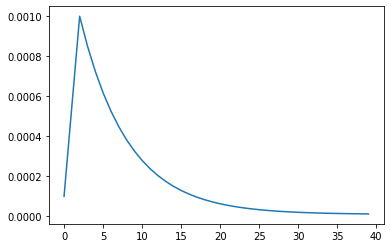

In [ ]:
# Learning rate scheduler callbacks
# optimizer (with 1-cycle-policy)
start_lr = 0.0001
min_lr = 0.00001
max_lr = 0.001 * strategy.num_replicas_in_sync
rampup_epochs = 2
sustain_epochs = 0
exp_decay = .85

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

#LEARNING_RATE = 0.001
#LEARNING_RATE_EXP_DECAY = 0.3 if strategy.num_replicas_in_sync == 1 else 0.5

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch, verbose=True)

rang = np.arange(NO_EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
hidden_size = 64
deepconn = DeepCoNN(hidden_size)

deepconn.train(train_dataset.shuffle(5000), batch_size=32, epochs=NO_EPOCHS, validation_dataset=test_dataset, callbacks=[tensorboard_callback, lr_callback, checkpoint_callback])

deepconn.model.save_weights(os.path.join(dir_prefix,f"baas-base_mean_layer-2-yelp-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.h5"))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_embedding (InputLayer)     [(None, 768)]        0                                            
__________________________________________________________________________________________________
item_embedding (InputLayer)     [(None, 768)]        0                                            
__________________________________________________________________________________________________
user_dense_64 (Dense)           (None, 64)           49216       user_embedding[0][0]             
__________________________________________________________________________________________________
item_dense_64 (Dense)           (None, 64)           49216       item_embedding[0][0]             
______________________________________________________________________________________________

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
np.__version__

'1.20.2'

In [ ]:
%tensorboard --logdir logs/tensorboard/base/

In [ ]:
# ---- If OOM, restart instance and load weights from here

In [ ]:
hidden_size = 64
deepconn = DeepCoNN(hidden_size)
deepconn.create_deepconn_dp()
deepconn.model.load_weights('/content/drive/MyDrive/W266/data/Yelp/baas-base_mean_layer-2-yelp-20210403-081001.h5')


In [10]:
# pool of all posssible review embeddings
held_out_test_raw_data = pd.read_pickle(os.path.join(dir_prefix,"yelp_held_out_test_dataset.pkl.gz")).drop_duplicates(subset=['asin','reviewerID'])
# the 'usable' rows which have >= 10 reviews per reviewerID and asin
held_out_test_usable = held_out_test_raw_data[(held_out_test_raw_data['userReviewsCount'] >=10) 
                                              & (held_out_test_raw_data['itemReviewsCount'] >=10) &
                                             (held_out_test_raw_data['userReviewsCount'] <=max_review_count)  &
                                             (held_out_test_raw_data['itemReviewsCount'] <=max_review_count)  ][['asin','reviewerID','overall']]
# sort the pool of possible review embeddings for quick retrieval
user_sorted_held_out = held_out_test_raw_data.sort_values('reviewerID')
item_sorted_held_out = held_out_test_raw_data.sort_values('asin')

In [12]:
print(f'Held out test size: {len(held_out_test_usable)}, {len(held_out_test_raw_data)}')

Held out test size: 14421, 115691


In [11]:
# same thing as training_dataset_generator but loops over test data
def held_out_test_dataset_generator():
    # iterate through each testing row
    for _, row in held_out_test_usable.iterrows():
        # get the grouped list of embedding vectors for userReviews and itemReviews
        yield dataset_generator(row, user_sorted_held_out, item_sorted_held_out)

# create tf.dataset object from generator w/ signature
held_out_test_dataset = tf.data.Dataset.from_generator(held_out_test_dataset_generator, 
                    output_signature=({'user_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32),
                                      'item_embedding': tf.TensorSpec(shape=(None, embedding_size), dtype=tf.float32)
                                      #'user_token_type_ids': tf.TensorSpec(shape=(None, None, max_sentence_length), dtype=tf.int32),
                                      #'user_attention_masks': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32),
                                      #'item_input_ids': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32),
                                      #'item_token_type_ids': tf.TensorSpec(shape=(None, None, max_sentence_length), dtype=tf.int32),
                                      #'item_attention_masks': tf.TensorSpec(shape=(None, None, max_sequence_length), dtype=tf.int32)
                    },
                           {'rating':tf.TensorSpec(shape=(None), dtype=tf.float32)}))


In [ ]:
for _ in tqdm(held_out_test_dataset, total=len(held_out_test_usable)):
    pass
len(embedding_cache)

273079

In [ ]:


true_rating = np.asarray([element[1]['rating'] for element in tqdm(held_out_test_dataset.as_numpy_iterator())])

predictions = deepconn.model.predict(held_out_test_dataset)

error = np.square(predictions - true_rating)

print("Held out MSE:", np.average(error))


Held out MSE: 0.9359364


In [16]:
held_out_test_usable.iloc[0]

asin          kCEoAKXMy729HsEFnASB3A
reviewerID    c0VLfFUo2PRzCdiMfVZi3A
overall                            3
Name: 5684043, dtype: object

In [18]:
true_rating = np.asarray([row['overall'] for _, row in tqdm(held_out_test_usable.iterrows(), total=len(held_out_test_usable))])

In [19]:
np.average(true_rating)

3.9848831565078706

In [20]:
np.average(np.square(np.repeat(3.9848831565078706, len(true_rating)) - true_rating))

1.0707096961458091